<a href="https://colab.research.google.com/github/Jkia65/Assignment-3-Python-Refresher/blob/main/Assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 11: Image Classification Using Random Forest

Step 1: Dataset Selection and Preprocessing:


In [1]:
# STEP 1 - Imports, upload ZIP, extract, load, resize, normalize, split

# Required Libraries
import os
import zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize

from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import joblib

# For Google Colab upload
from google.colab import files


# Upload ZIP
uploaded = files.upload()   # Select images.zip

# Extract ZIP
zip_file = list(uploaded.keys())[0]
extract_path = "/content/images"

with zipfile.ZipFile(zip_file, "r") as z:
    z.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path))


# Detect dataset root
subfolders = os.listdir(extract_path)
if len(subfolders) == 1 and os.path.isdir(os.path.join(extract_path, subfolders[0])):
    DATASET_PATH = os.path.join(extract_path, subfolders[0])
else:
    DATASET_PATH = extract_path

print("Dataset path:", DATASET_PATH)


# Image Loader Function
def load_image_files(container_path, dimension=(64,64)):
    image_dir = Path(container_path)
    folders = sorted([d for d in image_dir.iterdir() if d.is_dir()])
    categories = [f.name for f in folders]

    images, flat_data, target = [], [], []

    for label, folder in enumerate(folders):
        for file in folder.iterdir():
            try:
                img = io.imread(file)
            except:
                continue

            # Grayscale - RGB
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)

            # Resize and normalize
            img_resized = resize(img, dimension, anti_aliasing=True).astype(np.float32)

            images.append(img_resized)
            flat_data.append(img_resized.flatten())
            target.append(label)

    return Bunch(
        data=np.array(flat_data),
        images=np.array(images),
        target=np.array(target),
        target_names=categories
    )


# Load Dataset
IMAGE_DIM = (64, 64)
dataset = load_image_files(DATASET_PATH, IMAGE_DIM)

print("Classes:", dataset.target_names)
print("Total samples:", len(dataset.data))


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    dataset.data,
    dataset.target,
    test_size=0.3,
    random_state=42,
    stratify=dataset.target
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Saving images.zip to images (1).zip
Extracted folders: ['images']
Dataset path: /content/images/images
Classes: ['dalmatian', 'dollar_bill', 'pizza', 'soccer_ball', 'sunflower']
Total samples: 309
Train shape: (216, 12288)
Test shape: (93, 12288)


Step 2: Model Training:


In [2]:
# STEP 2 — Model Training (Random Forest + GridSearchCV)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)

print("Running GridSearchCV...")
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, verbose=2, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best Parameters:", grid_rf.best_params_)

best_rf = grid_rf.best_estimator_

# Save RF
joblib.dump(best_rf, "best_random_forest.joblib")
print("Random Forest Model Saved.")


Running GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Model Saved.


Step 3: Model Evaluation:


Accuracy: 0.6774193548387096

Classification Report:

              precision    recall  f1-score   support

   dalmatian       0.55      0.60      0.57        20
 dollar_bill       0.79      0.73      0.76        15
       pizza       0.88      0.44      0.58        16
 soccer_ball       0.53      0.62      0.57        16
   sunflower       0.77      0.88      0.82        26

    accuracy                           0.68        93
   macro avg       0.70      0.66      0.66        93
weighted avg       0.70      0.68      0.67        93



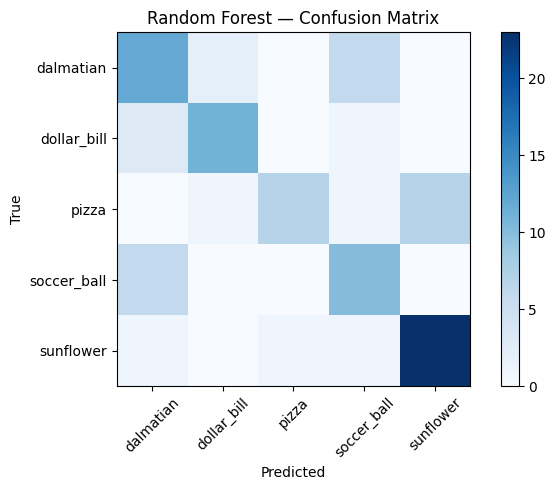

In [3]:
# STEP 3 — Model Evaluation (Accuracy, Precision, Recall, F1, Confusion Matrix)

y_pred_rf = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=dataset.target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(7,5))
plt.imshow(cm, cmap="Blues")
plt.title("Random Forest — Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(dataset.target_names)), dataset.target_names, rotation=45)
plt.yticks(range(len(dataset.target_names)), dataset.target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Step 4: Feature Importance Visualization


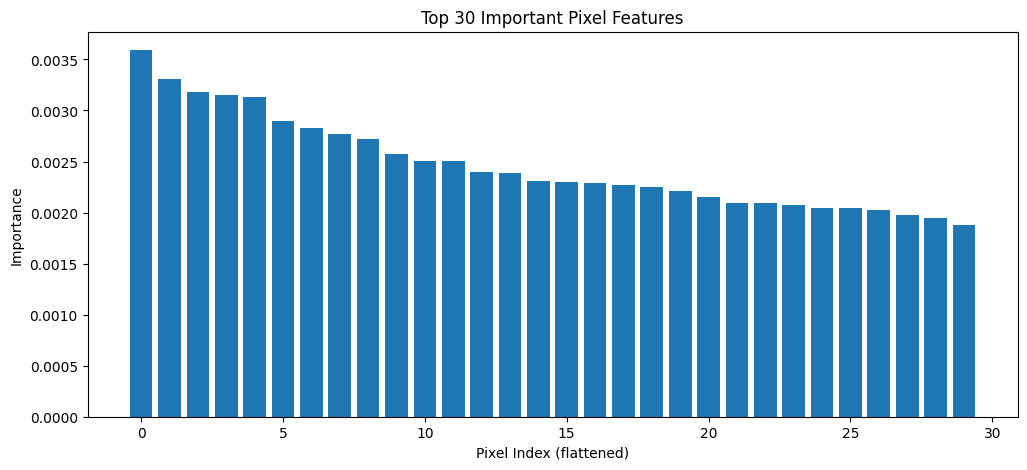

In [4]:
# STEP 4 — Feature Importance Visualization


importances = best_rf.feature_importances_

# Show top 30 important pixel features
idx = np.argsort(importances)[-30:][::-1]

plt.figure(figsize=(12,5))
plt.bar(range(30), importances[idx])
plt.title("Top 30 Important Pixel Features")
plt.xlabel("Pixel Index (flattened)")
plt.ylabel("Importance")
plt.show()

Step 5: Prediction on New Images

In [6]:
# STEP 5 — Prediction on New Images


def predict_image(img_path, model, dimension=(64, 64)):

    # Read image
    img = io.imread(img_path)

    # Convert grayscale to RGB
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)

    # Resize and normalize
    img_resized = resize(img, dimension, anti_aliasing=True).astype(np.float32)

    # Flatten
    flat = img_resized.flatten().reshape(1, -1)

    # Prediction
    pred = model.predict(flat)[0]

    return dataset.target_names[pred]

Step 6: Bonus: Comparing with SVM


In [7]:
# STEP 6 — SVM Classification (with PCA) + Comparison

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# PCA
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train_s)
X_test_pca = pca.transform(X_test_s)

# SVM Grid Search
param_grid_svm = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, verbose=2, n_jobs=-1)
grid_svm.fit(X_train_pca, y_train)

print("Best SVM parameters:", grid_svm.best_params_)

best_svm = grid_svm.best_estimator_

y_pred_svm = best_svm.predict(X_test_pca)

print("\nSVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nSVM Classification Report:\n")
print(classification_report(y_test, y_pred_svm, target_names=dataset.target_names))


# Comparison
print("====================")
print("MODEL COMPARISON")
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("====================")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best SVM parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

SVM Accuracy: 0.7741935483870968

SVM Classification Report:

              precision    recall  f1-score   support

   dalmatian       0.79      0.75      0.77        20
 dollar_bill       0.65      0.87      0.74        15
       pizza       0.91      0.62      0.74        16
 soccer_ball       0.67      0.62      0.65        16
   sunflower       0.86      0.92      0.89        26

    accuracy                           0.77        93
   macro avg       0.77      0.76      0.76        93
weighted avg       0.79      0.77      0.77        93

MODEL COMPARISON
Random Forest Accuracy: 0.6774193548387096
SVM Accuracy: 0.7741935483870968
